In [1]:
import sys
sys.path.insert(0, '../../../pyLDLE2/')
sys.path.insert(0, '../src/')

import numpy as np
import networkx as nx
import ConnectionNetworkX as cnx

from matplotlib import pyplot as plt
from matplotlib import cm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/nbks/../src/ConnectionNetworkX.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, edge_width=1, figsize=(8,4)):
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        ax.plot(*vizedge.T, color=edge_color[i], linewidth=edge_width)

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load data

In [4]:
X, labelsMat, _ = datasets.Datasets().sphere(n=2000)

X.shape =  (2000, 3)


<IPython.core.display.Javascript object>


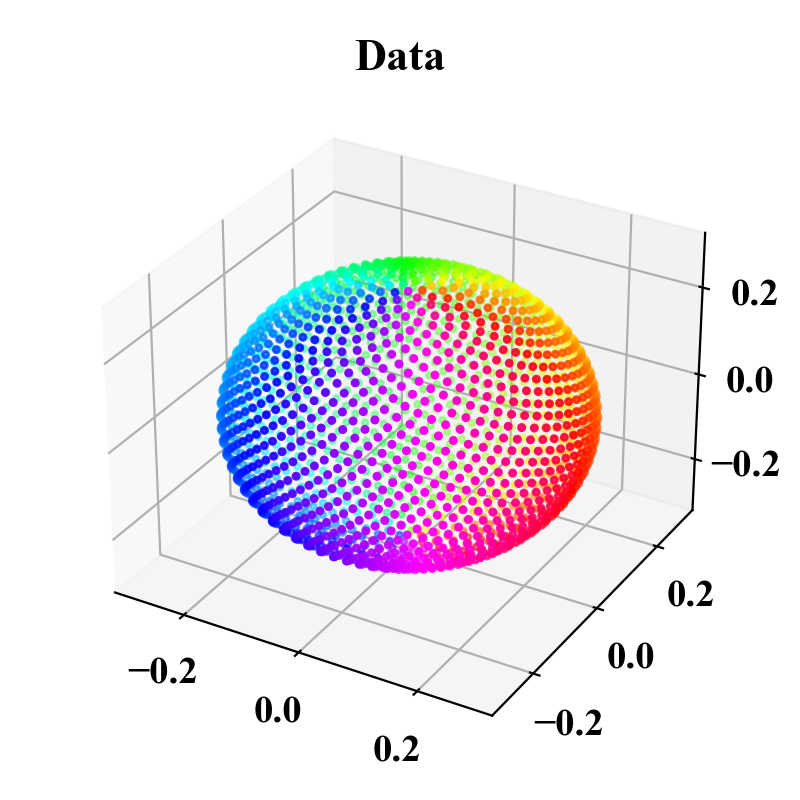

In [5]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

# Set source and destination nodes

In [6]:
source = 0
dest1 = 1597
dest2 = 1561

<IPython.core.display.Javascript object>


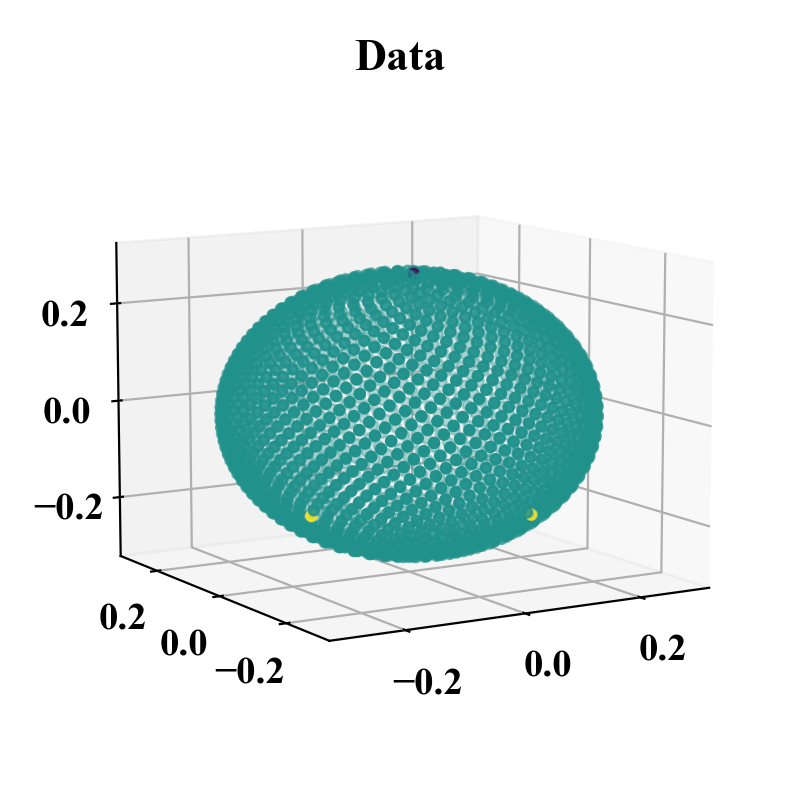

In [7]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[source] = -1
labels[dest1] = 1
labels[dest2] = 1
vis.data(X, labels, cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

#  Build connection graph

In [148]:
eps_pca = 0.05
eps = eps_pca
d = 2
CG = cnx.cnxFromData(X, eps_pca, eps, d=d, tol=0.5, kernel='linear', triv_sigma=False)

Total edges before removal: 15550


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2215.04it/s]


Proportion of edges which were removed due to remoteness:  0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.20it/s]


# Set B, w, mu, nu, c

In [149]:
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
w = np.array(list(nx.get_edge_attributes(CG, 'weight').values()))

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

# Plot c

<IPython.core.display.Javascript object>


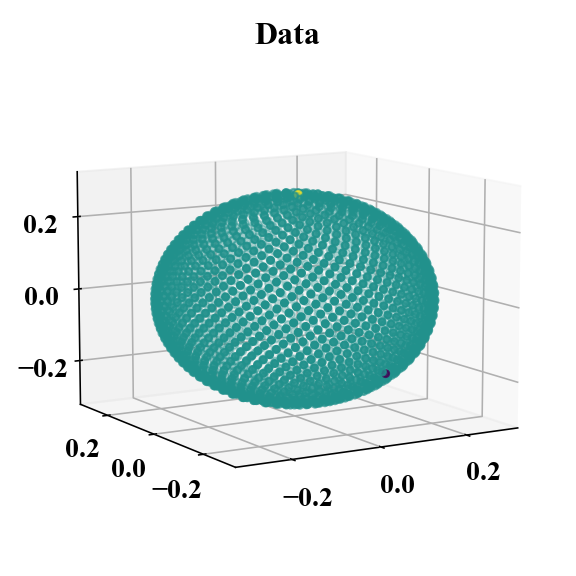

<IPython.core.display.Javascript object>


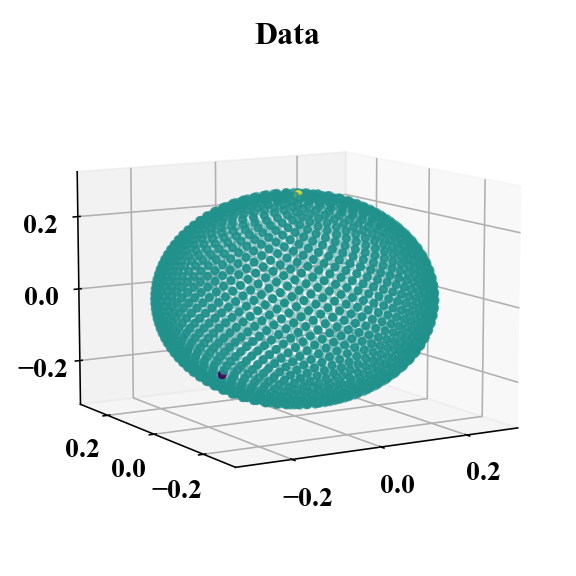

In [150]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, c.reshape((n,d))[:,0], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)
vis.data(X, c.reshape((n,d))[:,1], cmap='viridis', figsize=(4,4), s=50, elev=10, azim=-121)

# Check feasibility of primal i.e. $B^TJ = c$

In [151]:
temp_J, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c, rcond=None)
print('Error is:', np.linalg.norm(c.flatten() - B.T.dot(temp_J).flatten())) # if this is small then feasible

Error is: 1.2413784827307191e-14


# Solve Beckmann dual using gradient descent

In [189]:
learning_rate = 0.1
alpha = np.max(w)*50
n_epochs = 5000

phi, phi0 = cnx.optimize_(B, w, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

Initial loss: (tensor(-9.7657), tensor(6.0790))
epoch: 0, loss: -8.549929, loss0: -9.765734, loss1: 6.078954
epoch: 10, loss: -11.536580, loss0: -13.748730, loss1: 11.060618
epoch: 20, loss: -13.778437, loss0: -17.594223, loss1: 19.078711
epoch: 30, loss: -15.234880, loss0: -21.120365, loss1: 29.427076
epoch: 40, loss: -16.057236, loss0: -24.115673, loss1: 40.291721
epoch: 50, loss: -16.443100, loss0: -26.414505, loss1: 49.856438
epoch: 60, loss: -16.585899, loss0: -27.977365, loss1: 56.956657
epoch: 70, loss: -16.622828, loss0: -28.908545, loss1: 61.427868
epoch: 80, loss: -16.628389, loss0: -29.366873, loss1: 63.691673
epoch: 90, loss: -16.628670, loss0: -29.514812, loss1: 64.429955
epoch: 100, loss: -16.628712, loss0: -29.501461, loss1: 64.362991
epoch: 110, loss: -16.628819, loss0: -29.433720, loss1: 64.023750
epoch: 120, loss: -16.629084, loss0: -29.367197, loss1: 63.689823
epoch: 130, loss: -16.629148, loss0: -29.323685, loss1: 63.471939
epoch: 140, loss: -16.629257, loss0: -29.3

epoch: 1250, loss: -16.627331, loss0: -29.312557, loss1: 63.425388
epoch: 1260, loss: -16.628956, loss0: -29.312269, loss1: 63.415829
epoch: 1270, loss: -16.629112, loss0: -29.312746, loss1: 63.417423
epoch: 1280, loss: -16.629044, loss0: -29.312872, loss1: 63.418396
epoch: 1290, loss: -16.628290, loss0: -29.312737, loss1: 63.421490
epoch: 1300, loss: -16.628452, loss0: -29.312553, loss1: 63.419758
epoch: 1310, loss: -16.627869, loss0: -29.312515, loss1: 63.422497
epoch: 1320, loss: -16.628944, loss0: -29.312332, loss1: 63.416203
epoch: 1330, loss: -16.629028, loss0: -29.312574, loss1: 63.416988
epoch: 1340, loss: -16.628025, loss0: -29.312872, loss1: 63.423489
epoch: 1350, loss: -16.628859, loss0: -29.312519, loss1: 63.417561
epoch: 1360, loss: -16.628677, loss0: -29.312506, loss1: 63.418404
epoch: 1370, loss: -16.628616, loss0: -29.312695, loss1: 63.419643
epoch: 1380, loss: -16.628294, loss0: -29.312614, loss1: 63.420860
epoch: 1390, loss: -16.628777, loss0: -29.312584, loss1: 63.41

epoch: 2490, loss: -16.627777, loss0: -29.312157, loss1: 63.421150
epoch: 2500, loss: -16.627724, loss0: -29.310812, loss1: 63.414700
epoch: 2510, loss: -16.628115, loss0: -29.311520, loss1: 63.416283
epoch: 2520, loss: -16.613243, loss0: -29.310358, loss1: 63.484833
epoch: 2530, loss: -16.598614, loss0: -29.291557, loss1: 63.463970
epoch: 2540, loss: -16.562355, loss0: -29.276062, loss1: 63.567791
epoch: 2550, loss: -16.538479, loss0: -29.248371, loss1: 63.548714
epoch: 2560, loss: -16.590151, loss0: -29.235903, loss1: 63.228020
epoch: 2570, loss: -16.617504, loss0: -29.302725, loss1: 63.425365
epoch: 2580, loss: -16.626270, loss0: -29.314232, loss1: 63.439060
epoch: 2590, loss: -16.628780, loss0: -29.299870, loss1: 63.354698
epoch: 2600, loss: -16.629351, loss0: -29.316229, loss1: 63.433647
epoch: 2610, loss: -16.629070, loss0: -29.311504, loss1: 63.411434
epoch: 2620, loss: -16.629436, loss0: -29.312714, loss1: 63.415649
epoch: 2630, loss: -16.628857, loss0: -29.312704, loss1: 63.41

epoch: 3730, loss: -16.628643, loss0: -29.312622, loss1: 63.419155
epoch: 3740, loss: -16.629124, loss0: -29.312521, loss1: 63.416241
epoch: 3750, loss: -16.628925, loss0: -29.312700, loss1: 63.418133
epoch: 3760, loss: -16.627060, loss0: -29.312122, loss1: 63.424568
epoch: 3770, loss: -16.628647, loss0: -29.311377, loss1: 63.412907
epoch: 3780, loss: -16.627869, loss0: -29.313026, loss1: 63.425049
epoch: 3790, loss: -16.628735, loss0: -29.311646, loss1: 63.413818
epoch: 3800, loss: -16.628578, loss0: -29.312958, loss1: 63.421154
epoch: 3810, loss: -16.628056, loss0: -29.312660, loss1: 63.422287
epoch: 3820, loss: -16.628082, loss0: -29.312128, loss1: 63.419479
epoch: 3830, loss: -16.628876, loss0: -29.312103, loss1: 63.415398
epoch: 3840, loss: -16.628510, loss0: -29.313049, loss1: 63.421955
epoch: 3850, loss: -16.628279, loss0: -29.312319, loss1: 63.419456
epoch: 3860, loss: -16.628345, loss0: -29.312830, loss1: 63.421677
epoch: 3870, loss: -16.628952, loss0: -29.312241, loss1: 63.41

epoch: 4970, loss: -16.628639, loss0: -29.312416, loss1: 63.418140
epoch: 4980, loss: -16.627689, loss0: -29.312250, loss1: 63.422058
epoch: 4990, loss: -16.628149, loss0: -29.312445, loss1: 63.420734


# Compute activeness of edges and optimal primal

In [190]:
edge_score = cnx.activenes_of_edges(phi, B, w, c)
J_opt = cnx.optimal_primal(phi, B, w, c, alpha, d) # the mean abs error should be small

mean abs err of sum_{v in V} ||(B^TJ-c)(v)||_1 0.0022550840719809057


In [191]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)

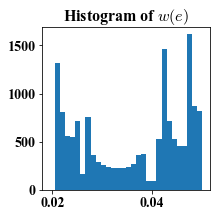

In [192]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

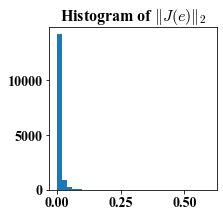

In [193]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

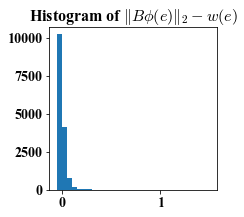

In [194]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

# Plot optimal flow

In [195]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap

to_embed = None # no need to embed if the data is already in <= 3 dimensions, else use isomap/ltsa
embed_dim = None
if to_embed is not None:
    if to_embed == 'isomap':
        fit_obj = Isomap(n_components=embed_dim, n_neighbors=10)
    else:
        fit_obj = LocallyLinearEmbedding(n_components=embed_dim, n_neighbors=10, method='ltsa')
    embedding = fit_obj.fit_transform(X)
else:
    embedding = X

In [196]:
J = J_opt

<IPython.core.display.Javascript object>


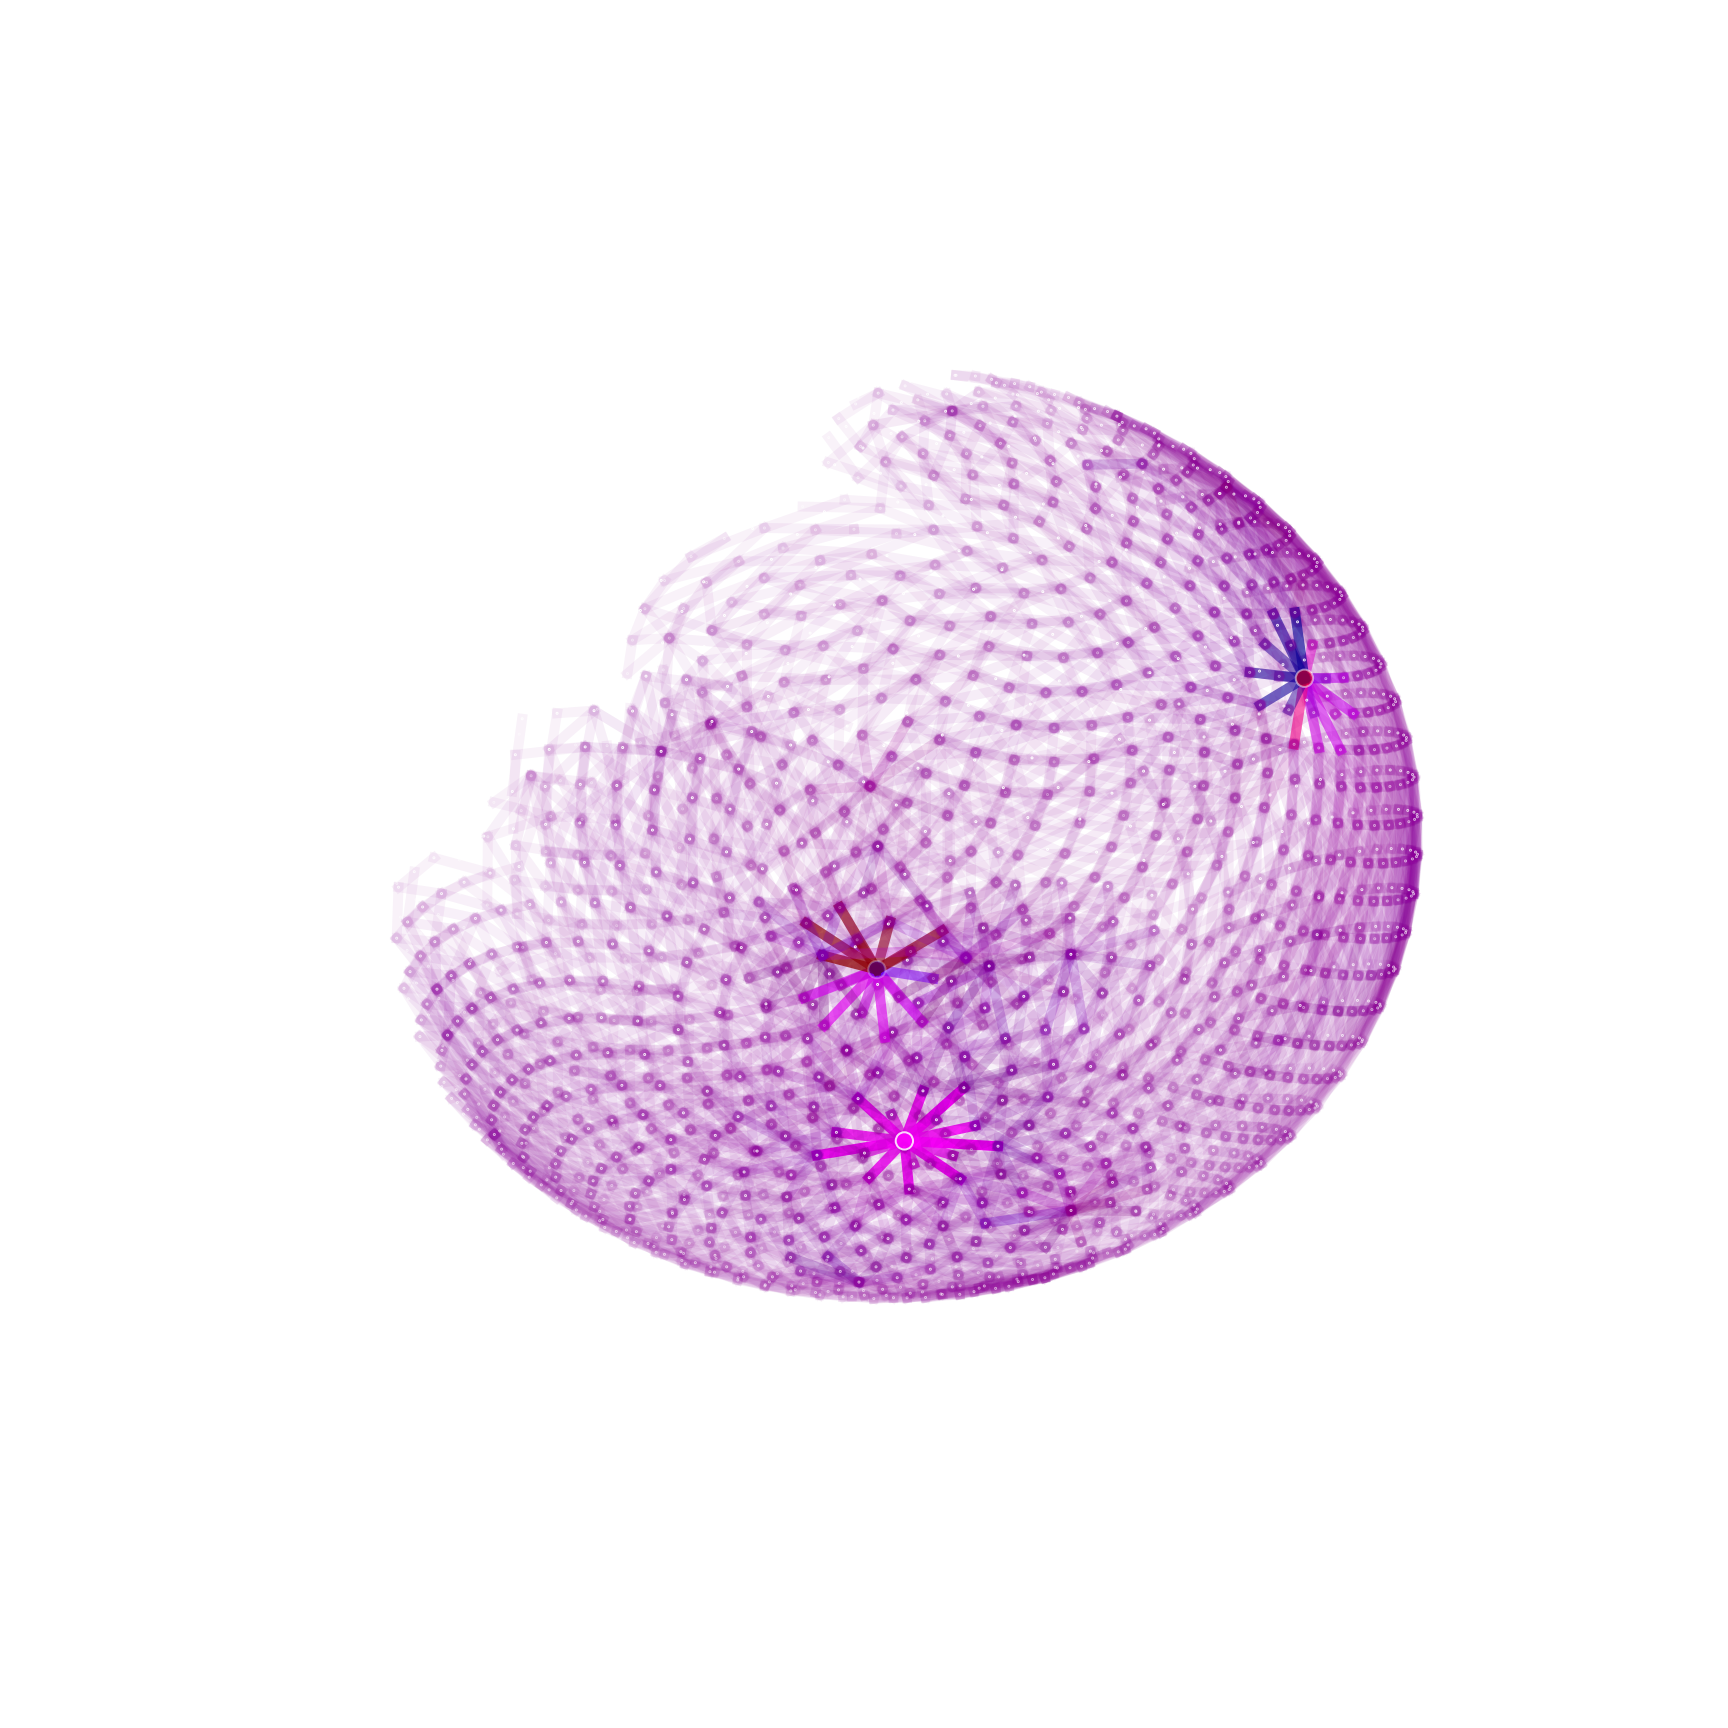

/tmp/ipykernel_63368/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [197]:
%matplotlib notebook

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,0,1,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,0,1,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,2] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

<IPython.core.display.Javascript object>


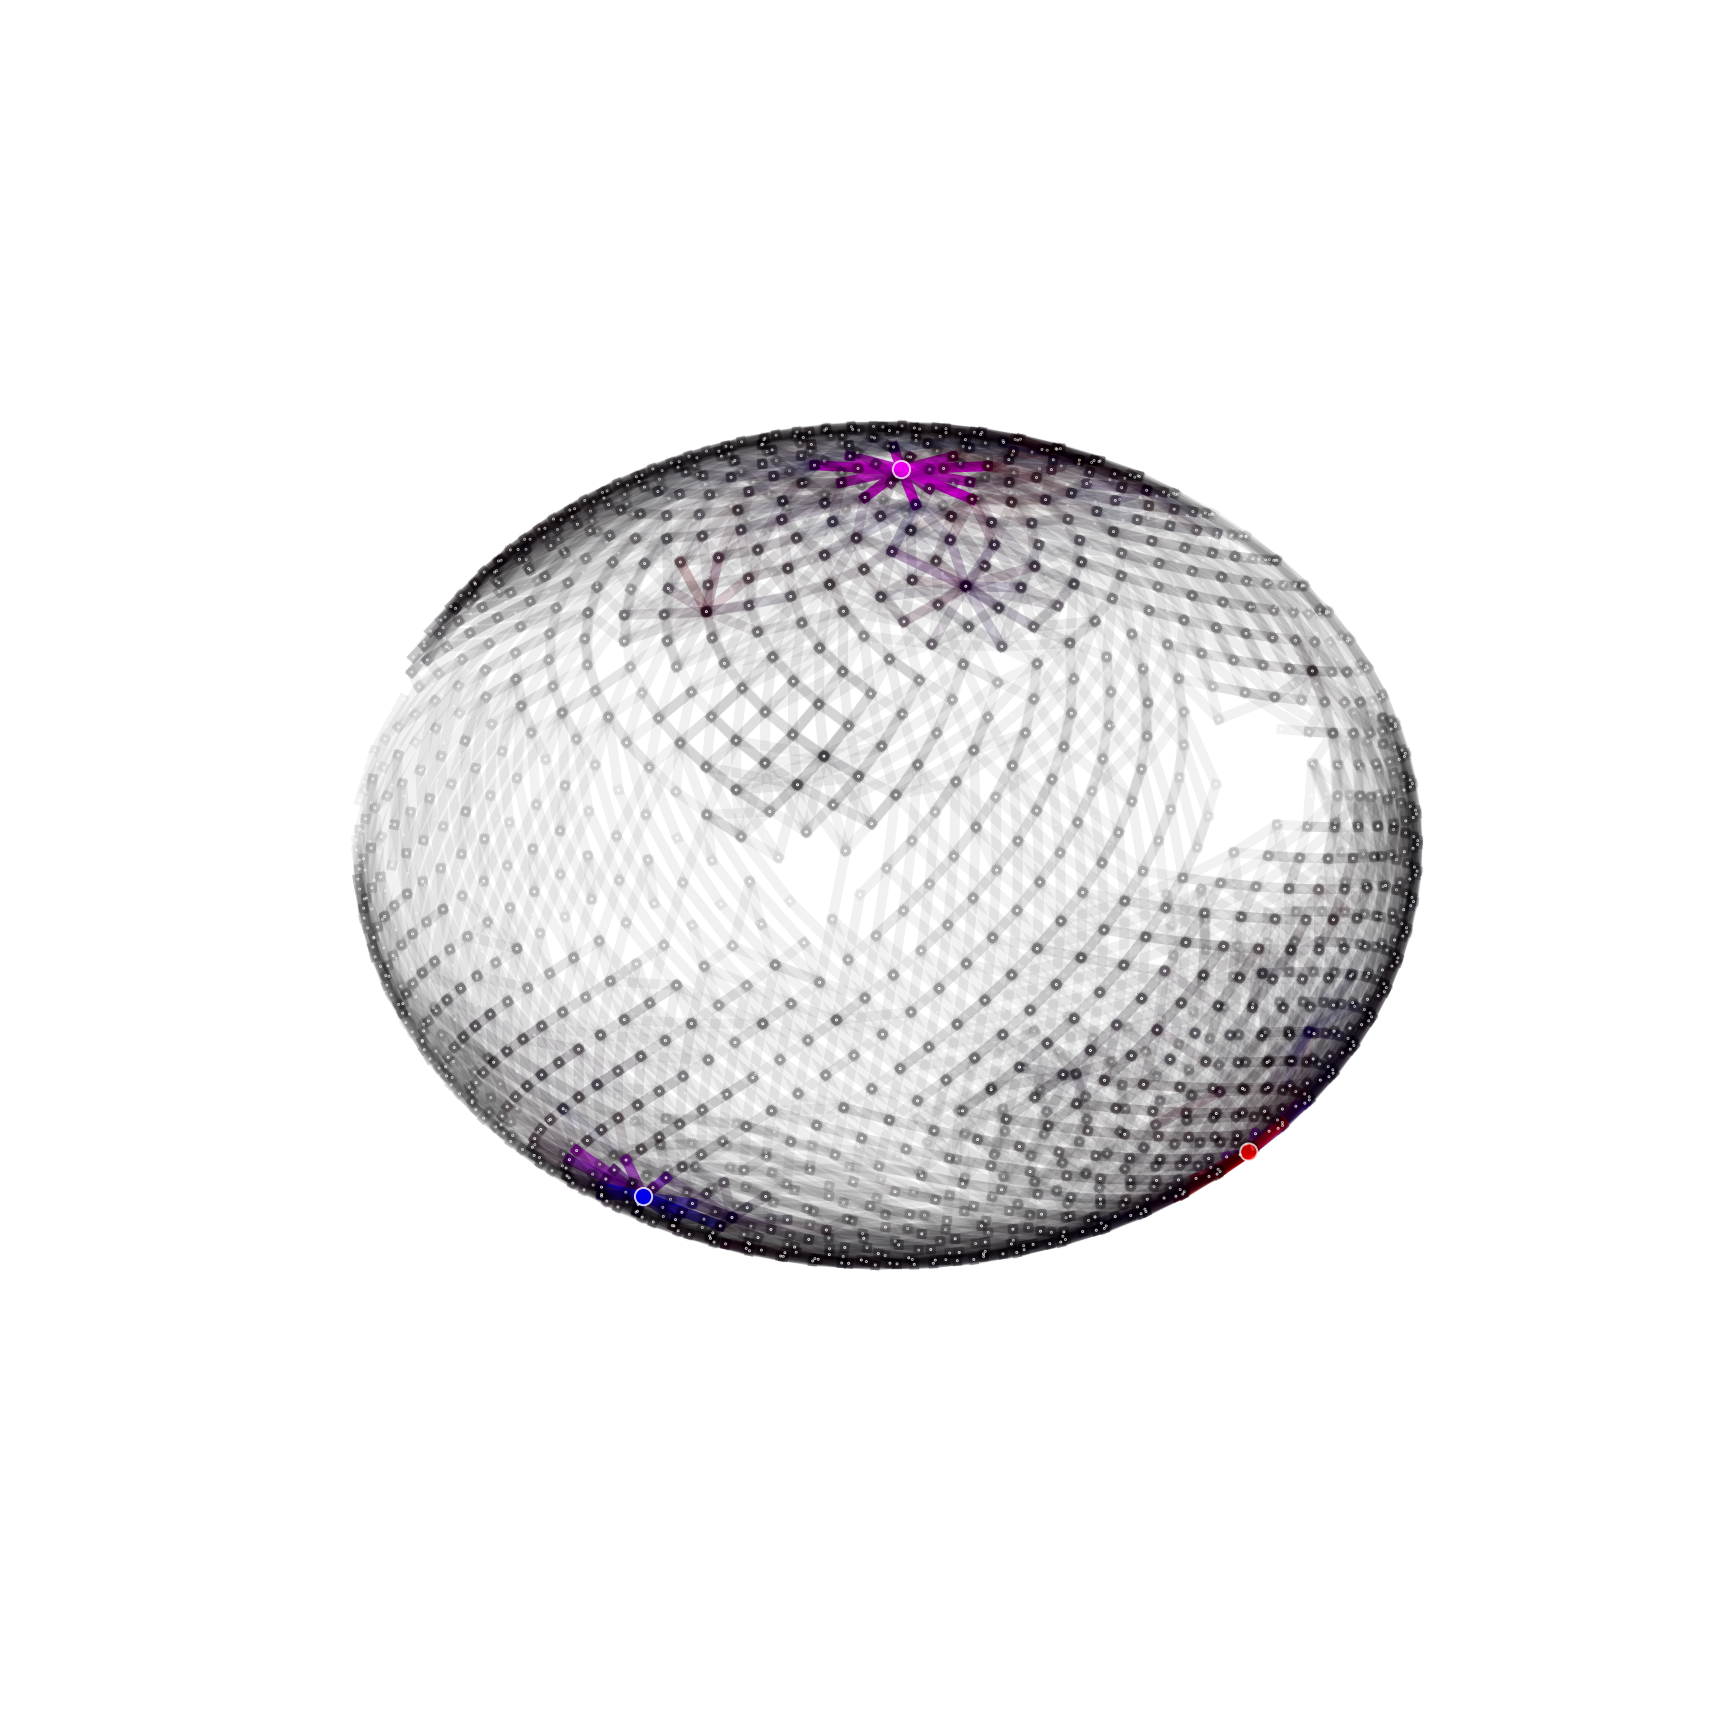

/tmp/ipykernel_63368/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [201]:
%matplotlib notebook
node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,0,1,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,0,1,1]

mask = (edge_score > 0)
J_ = J[mask,:]
mJ_ = np.max(np.abs(J_))

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = np.abs(J_[:,0])/mJ_
edge_color[mask,2] = np.abs(J_[:,1])/mJ_
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=5, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()

# Plot optimal phi

In [199]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

<IPython.core.display.Javascript object>


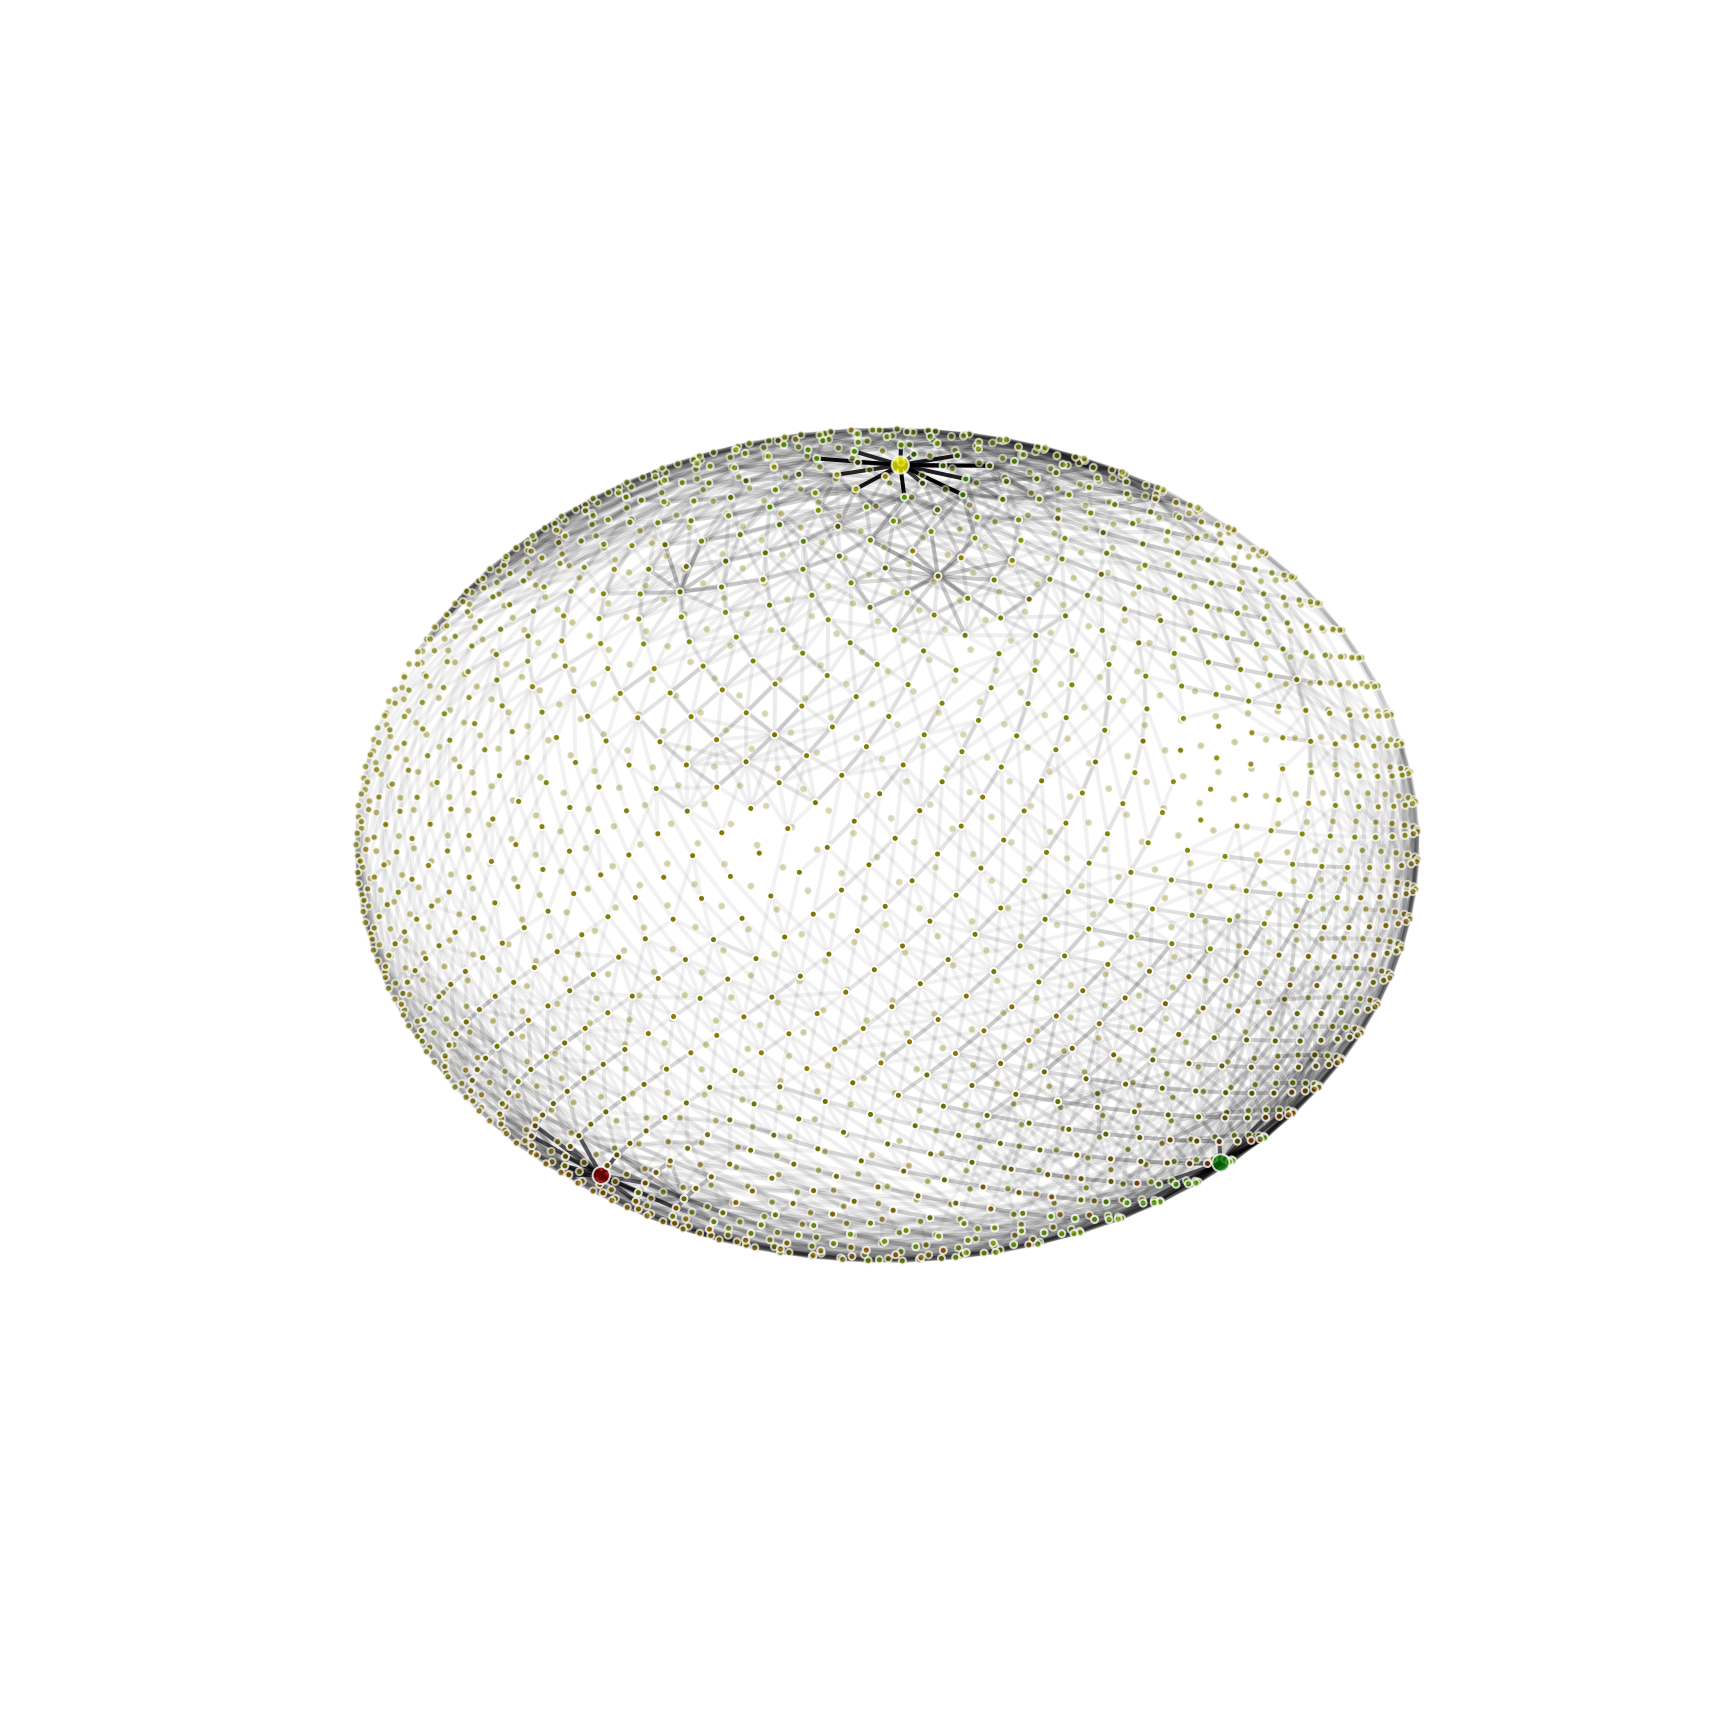

/tmp/ipykernel_63368/2176903746.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


In [200]:
%matplotlib notebook
node_size = np.ones(n)*50
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300

node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = (node_color_[:,0] - np.min(node_color_[:,0]))/np.ptp(node_color_[:,0])
node_color[:,1] = (node_color_[:,1] - np.min(node_color_[:,1]))/np.ptp(node_color_[:,1])

mask = (edge_score > 0)

edge_color = np.zeros((edge_score.shape[0],4))
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, edge_width=2, figsize=(12, 12))
plt.gca().view_init(elev=20, azim=-119)
plt.show()